Imports.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#import sys
#sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#from eikonal_routines import *

In [4]:
from queue import PriorityQueue

Parameters.

In [5]:
# Number of discretization points
N = 101

# Refraction index (NxN matrix)
F = np.ones((N, N))

# Source points - boundary conditions (Nx3 matrix)
#                 first column    -  x coordinates of the source
#                 second column   -  y coordinates of the source
#                 third column    -  eikonal(x,y)
source = np.array([
    [21, 21, 1],
    [71, 71, 2]
])
#source = np.array([
#    [11, 11, 0]
#])

# Grid spacing
h = 0.1

# Tolerance used as a stopping criterion
tol = 1e-6

# Large value
infinity = 10 * (N * h) ** 2

Initializations.

In [6]:
# Eikonal initialization
u = np.full((N, N), infinity)

# Mask matrix for already set nodes
isSet = np.full((N, N), False)

# Adding the sources
activeList = PriorityQueue()
for n in range(len(source)):
    u[source[n, 0], source[n, 1]] = source[n, 2]
    activeList.put((source[n, 2], source[n, 0], source[n, 1]))

In [7]:
def update_coefficients(switch, alpha, alpha_prime, t, a, b, c):
  alphatrue   = (switch * alpha + (1 - switch) * alpha_prime)
  beta        = -(2 * t * alphatrue)
  gamma       =  (t**2) * alphatrue
  a           += alphatrue
  b           += beta
  c           += gamma

  return a, b, c

def update_eikonal_second_order(i, j, u, F, isSet, h, N):

  a = 0
  b = 0
  c = -(F[i, j]**2)

  alpha = 1 / (h**2)
  alpha_prime = 9 / (4 * (h**2))

  switch = True
  # --- Leftmost boundary
  if i == 0:
    ta          = u[i + 1, j]
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, ta, a, b, c)
  # --- Leftmost but one boundary
  elif i == 1:
    ta = min(u[i + 1, j], u[i - 1, j])
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, ta, a, b, c)
  # --- Rightmost boundary
  elif i == N - 1:
    ta = u[i - 1, j]
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, ta, a, b, c)
  # --- Rightmost but one boundary
  elif i == N - 2:
    ta = min(u[i + 1, j], u[i - 1, j])
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, ta, a, b, c)
  else:
    switch1 = False
    switch2 = False
    if isSet[i - 2, j] & isSet[i - 1, j] & (u[i - 2, j] < u[i - 1, j]):
      tprimea1 = (4 * u[i - 1, j] - u[i - 2, j]) / 3
    else:
      tprimea1 = u[i - 1, j]
      switch1  = True
    if isSet[i + 2, j] & isSet[i + 1, j] & (u[i + 2, j] < u[i + 1, j]):
      tprimea2 = (4 * u[i + 1, j] - u[i + 2, j]) / 3
    else:
      tprimea2 = u[i + 1, j]
      switch2  = True
    if tprimea1 < tprimea2:
      ta = tprimea1
      switch = switch1
    else:
      ta = tprimea2
      switch = switch2
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, ta, a, b, c)

  switch = True
  # --- Lowermost boundary
  if j == 0:
    tb          = u[i, j + 1]
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, tb, a, b, c)
  # --- Lowermost but one boundary
  elif j == 1:
    tb = min(u[i, j + 1], u[i, j - 1])
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, tb, a, b, c)
  # --- Rightmost boundary
  elif j == N - 1:
    tb = u[i, j - 1]
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, tb, a, b, c)
  # --- Rightmost but one boundary
  elif j == N - 2:
    tb = min(u[i, j + 1], u[i, j - 1])
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, tb, a, b, c)
  else:
    switch1 = False
    switch2 = False
    if isSet[i, j - 2] & isSet[i, j - 1] & (u[i, j - 2] < u[i, j - 1]):
      tprimea1 = (4 * u[i, j - 1] - u[i, j - 2]) / 3
    else:
      tprimea1 = u[i, j - 1]
      switch1  = True
    if isSet[i, j + 2] & isSet[i, j + 1] & (u[i, j + 2] < u[i, j + 1]):
      tprimea2 = (4 * u[i, j + 1] - u[i, j + 2]) / 3
    else:
      tprimea2 = u[i, j + 1]
      switch2  = True
    if tprimea1 < tprimea2:
      tb = tprimea1
      switch = switch1
    else:
      tb = tprimea2
      switch = switch2
    a, b, c     = update_coefficients(switch, alpha, alpha_prime, tb, a, b, c)

  # EIKONAL UPDATE
  discriminant = b**2 - 4 * a * c
  if discriminant >= 0:
    u_new = (-b + np.sqrt(discriminant)) / (2 * a)
    result = min(u[i, j], u_new)
  else:
    result = h * F[i, j] + min(ta, tb)

  return result

In [8]:
# FAST MARCHING ITERATIONS
while not (activeList.empty()):

    activeNode = activeList.get()

    isSet[activeNode[1], activeNode[2]] = True

    neighbors       = []

    neighbors.append((activeNode[1], activeNode[2] - 1))
    neighbors.append((activeNode[1], activeNode[2] + 1))
    neighbors.append((activeNode[1] - 1, activeNode[2]))
    neighbors.append((activeNode[1] + 1, activeNode[2]))

    while len(neighbors) > 0:
      neighbor = neighbors.pop()

      if ((neighbor[0] < N) & (neighbor[0] >= 0) & (neighbor[1] < N) & (neighbor[1] >= 0)):
        if ((isSet[neighbor] == False)):

          u[neighbor[0], neighbor[1]] = update_eikonal_second_order(neighbor[0], neighbor[1], u, F, isSet, h, N)

          shouldInsert = True
          candidate = (u[neighbor[0], neighbor[1]], neighbor[0], neighbor[1])
          for item in activeList.queue:
            if candidate == item:
              shouldInsert = False
          #print(any(candidate in item for item in activeList.queue))
          if shouldInsert:
            activeList.put((u[neighbor[0], neighbor[1]], neighbor[0], neighbor[1]))


Plots.

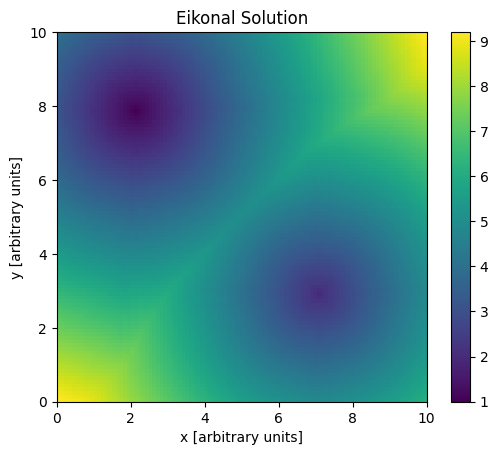

In [9]:
x = np.arange(0, N) * h
y = np.arange(0, N) * h

plt.figure(1)
plt.imshow(u, extent=(x[0], x[-1], y[0], y[-1]))
plt.colorbar()
plt.xlabel('x [arbitrary units]')
plt.ylabel('y [arbitrary units]')
plt.title('Eikonal Solution')
plt.show()